In [1]:
# 01. CARREGAMENTO DE BIBLIOTECAS ESSENCIAIS

# Se os pacotes ainda não estiverem instalados, instale-os:
# install.packages(c("caret", "dplyr", "mlbench", "pROC", "kernlab", "rpart", "randomForest", "gbm"))

# Pacotes Fundamentais
library(caret)
library(dplyr)
library(mlbench)
library(pROC)
library(ggplot2)

# Pacotes Específicos para os Modelos (Carregue APENAS o que for usar no notebook)
library(kernlab)   # Para SVM
# library(klaR)    # Para Naive Bayes
# library(MASS)    # Para LDA
# library(rpart)   # Para Árvores de Decisão
# library(randomForest) # Para Random Forest
# library(gbm)     # Para GBM

Carregando pacotes exigidos: ggplot2

Carregando pacotes exigidos: lattice


Anexando pacote: 'dplyr'


Os seguintes objetos são mascarados por 'package:stats':

    filter, lag


Os seguintes objetos são mascarados por 'package:base':

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Anexando pacote: 'pROC'


Os seguintes objetos são mascarados por 'package:stats':

    cov, smooth, var



Anexando pacote: 'kernlab'


O seguinte objeto é mascarado por 'package:ggplot2':

    alpha




In [2]:
# 02. Carregar dados
load("data/03_classification_data_splits.RData") 

# Carregar as configurações de controle
control <- readRDS("config/train_control.rds")

# Carregar o modelo RegLog Otimizado para comparação
logreg_otimizado <- readRDS("models/logreg_otimizado.rds")

# Carregar o modelo nb Otimizado para comparação
nb_model <- readRDS("models/nb_model.rds")

# Carregar o modelo lda Otimizado para comparação
lda_model <- readRDS("models/lda_model.rds")

# Carregar o modelo svm Otimizado para comparação
svm_model <- readRDS("models/svm_model.rds")

# Verificar se carregou
print(dim(train_df))

[1] 538   9


In [3]:
# --- CÉLULA 3: TREINAMENTO DO MODELO K-NEAREST NEIGHBORS (KNN) ---

message("Treinando Modelo K-Nearest Neighbors (KNN)...")

# O método 'knn' no caret não requer pacotes adicionais além do 'caret'
# Otimiza o parâmetro 'k'

knn_model <- train(
    diabetes ~ ., 
    data = train_df, 
    method = "knn",                 # Método para K-Nearest Neighbors
    metric = "ROC", 
    trControl = control, 
    preProcess = c("center", "scale"), 
    tuneLength = 15                 # Otimiza k de 1 a 15 (padrão)
)

# Salvar o modelo final (muito útil para a comparação)
saveRDS(knn_model, file = "models/knn_model.rds")

print(knn_model)

Treinando Modelo K-Nearest Neighbors (KNN)...



k-Nearest Neighbors 

538 samples
  8 predictor
  2 classes: 'Nao_Diabete', 'Diabete' 

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 484, 484, 484, 485, 484, 485, ... 
Resampling results across tuning parameters:

  k   ROC        Sens       Spec     
   5  0.7416277  0.8571429  0.4793372
   7  0.7529393  0.8628571  0.4576998
   9  0.7654080  0.8847619  0.4703704
  11  0.7770510  0.8885714  0.4720273
  13  0.7815107  0.8923810  0.4507797
  15  0.7830521  0.9133333  0.4436647
  17  0.7847313  0.9142857  0.4329435
  19  0.7869758  0.9142857  0.4292398
  21  0.7915845  0.9247619  0.4290448
  23  0.7971206  0.9219048  0.4346979
  25  0.7990727  0.9285714  0.4275828
  27  0.8011292  0.9333333  0.4274854
  29  0.8001211  0.9323810  0.4150097
  31  0.8025230  0.9323810  0.4059454
  33  0.8030354  0.9380952  0.4058480

ROC was used to select the optimal model using the largest value.
The final value used for the mod

Setting direction: controls < cases



[1] "AUC no Conjunto de Teste (Antes do ajuste de Threshold): 0.8335"



--- Análise do Melhor Threshold (Melhor Equilíbrio) ---



[1] "Melhor Threshold (T): 0.2879"
[1] "Sensibilidade (Novo Recall): 0.8375"
[1] "Especificidade (Nova Spec): 0.7133"
[1] "Acurácia Balanceada: 0.7754"



--- Matriz de Confusão Reclassificada (Threshold Otimizado) ---



Confusion Matrix and Statistics

             Reference
Prediction    Nao_Diabete Diabete
  Nao_Diabete         107      13
  Diabete              43      67
                                          
               Accuracy : 0.7565          
                 95% CI : (0.6958, 0.8105)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : 0.0004210       
                                          
                  Kappa : 0.5065          
                                          
 Mcnemar's Test P-Value : 0.0001065       
                                          
            Sensitivity : 0.8375          
            Specificity : 0.7133          
         Pos Pred Value : 0.6091          
         Neg Pred Value : 0.8917          
             Prevalence : 0.3478          
         Detection Rate : 0.2913          
   Detection Prevalence : 0.4783          
      Balanced Accuracy : 0.7754          
                                          
       'Positive' Class :

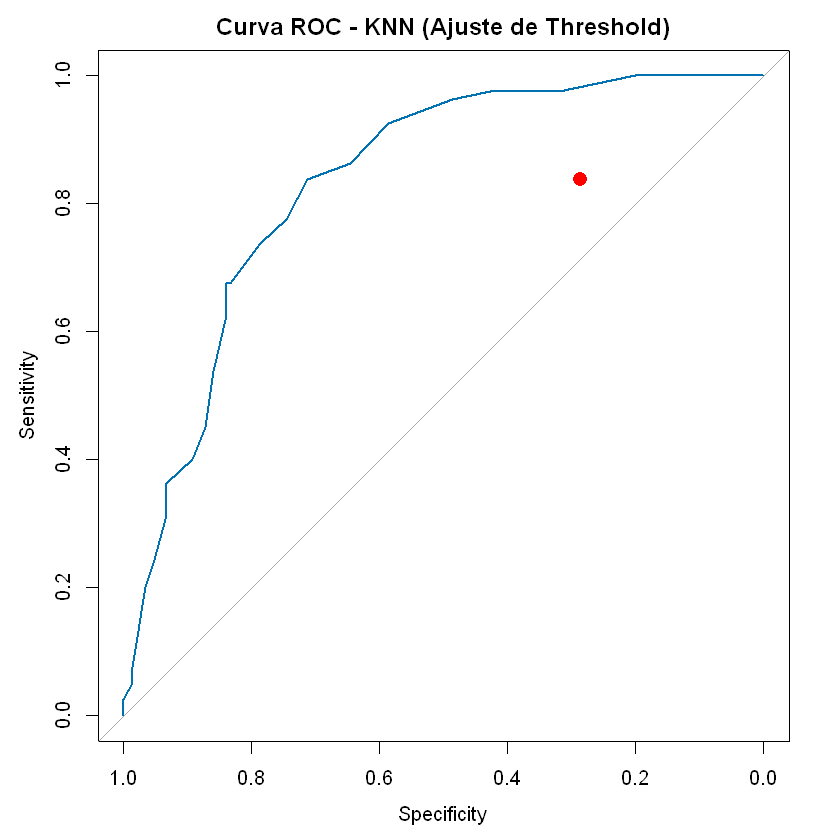

In [4]:
# --- CÉLULA 4: AJUSTE DE THRESHOLD PARA O MODELO KNN ---

# 1. Fazer Previsões de PROBABILIDADE no Conjunto de Teste
# (Certifique-se de que o knn_model está na memória ou foi carregado via readRDS())

predictions_prob <- predict(knn_model, newdata = test_df, type = "prob")
test_labels <- test_df$diabetes

# 2. Gerar a Curva ROC para Análise
library(pROC)
roc_curve <- roc(response = test_labels, 
                 predictor = predictions_prob$Diabete, 
                 levels = levels(test_labels))

print(paste("AUC no Conjunto de Teste (Antes do ajuste de Threshold):", round(auc(roc_curve), 4)))

# 3. IDENTIFICAR O MELHOR THRESHOLD
# A métrica 'closest.topleft' (ponto mais próximo ao canto superior esquerdo da curva) 
# maximiza o Recall E a Especificidade simultaneamente.
coords_data <- coords(roc_curve, "best", ret = c("threshold", "sens", "spec", "accuracy"), transpose = FALSE)

best_threshold <- coords_data$threshold
best_sens <- coords_data$sens
best_spec <- coords_data$spec

message("\n--- Análise do Melhor Threshold (Melhor Equilíbrio) ---")
print(paste("Melhor Threshold (T):", round(best_threshold, 4)))
print(paste("Sensibilidade (Novo Recall):", round(best_sens, 4)))
print(paste("Especificidade (Nova Spec):", round(best_spec, 4)))
print(paste("Acurácia Balanceada:", round((best_sens + best_spec) / 2, 4)))

# 4. APLICAR O NOVO THRESHOLD para obter a Matriz de Confusão

# Reclassificar as previsões de acordo com o novo threshold
predictions_reclassed <- factor(
    ifelse(predictions_prob$Diabete >= best_threshold, "Diabete", "Nao_Diabete"), 
    levels = levels(test_labels)
)

# Gerar a nova Matriz de Confusão
conf_matrix_reclassed <- confusionMatrix(predictions_reclassed, test_labels, positive = "Diabete")

message("\n--- Matriz de Confusão Reclassificada (Threshold Otimizado) ---")
print(conf_matrix_reclassed)

# 5. Plot da Curva ROC (Visualização da performance)
plot(roc_curve, 
     main = "Curva ROC - KNN (Ajuste de Threshold)", 
     col = "#0072B2", 
     lwd = 2)
points(1 - best_spec, best_sens, pch = 16, col = "red", cex = 1.5) # Marca o novo ponto

# Fim da Célula 5